### load packages

In [1]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ! pip install pyarrow fastparquet tqdm seaborn

### load data for range of time of choice
Two years and three months of data.

In [3]:
# preprocess months and years to an (N,2)-array
months = np.arange(1,12+1,1)
years = np.arange(2022,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

# add three months
month_year = np.vstack([month_year, [2024,1], [2024,2], [2024,3]])

In [4]:
month_year

array([[2022,    1],
       [2022,    2],
       [2022,    3],
       [2022,    4],
       [2022,    5],
       [2022,    6],
       [2022,    7],
       [2022,    8],
       [2022,    9],
       [2022,   10],
       [2022,   11],
       [2022,   12],
       [2023,    1],
       [2023,    2],
       [2023,    3],
       [2023,    4],
       [2023,    5],
       [2023,    6],
       [2023,    7],
       [2023,    8],
       [2023,    9],
       [2023,   10],
       [2023,   11],
       [2023,   12],
       [2024,    1],
       [2024,    2],
       [2024,    3]])

### Filter Manhattan Only and Remove Islands as in 01_e_adjacency_graph.ipynb

In [5]:
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

In [6]:
# generate data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID', 'DOLocationID'], additional_features=True, taxi_zones=taxi_zones)
ts.head()

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [03:18<00:00,  7.36s/it]


,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance
0,2022-01-01 00:00:00-05:00,4,4,0,0.0,0.0,0.0,0.0
1,2022-01-01 00:00:00-05:00,13,4,0,0.0,0.0,0.0,0.0
2,2022-01-01 00:00:00-05:00,24,4,0,0.0,0.0,0.0,0.0
3,2022-01-01 00:00:00-05:00,41,4,0,0.0,0.0,0.0,0.0
4,2022-01-01 00:00:00-05:00,42,4,0,0.0,0.0,0.0,0.0


In [7]:
ts.pickup_datetime.min(), ts.pickup_datetime.max()

(Timestamp('2022-01-01 00:00:00-0500', tz='America/New_York'),
 Timestamp('2024-03-31 23:00:00-0400', tz='America/New_York'))

In [8]:
# basic checks, notice our code accounts for Daylight Savings Time
print('Min Date: ', ts.pickup_datetime.min())
print('Max Date: ', ts.pickup_datetime.max())
print('Taxi Zones: ' + str(ts.PULocationID.unique().min()) + ' to ' + str(ts.PULocationID.unique().max()) )
print('Memory Usage (MB): ', ts.memory_usage().sum() / 1024**2)

Min Date:  2022-01-01 00:00:00-05:00
Max Date:  2024-03-31 23:00:00-04:00
Taxi Zones: 4 to 263
Memory Usage (MB):  2515.7399711608887


In [9]:
ts.dtypes

pickup_datetime    datetime64[us, America/New_York]
DOLocationID                                  int32
PULocationID                                  int32
counts                                        int32
total_amount                                float32
tip_amount                                  float32
fare_amount                                 float32
trip_distance                               float32
dtype: object

### obtain time series for a single time zone (East Village)

In [10]:
ts_79 = ts[ts['PULocationID'] == 79]
gb = ts_79.groupby(['pickup_datetime', 'PULocationID'])

In [11]:
# weighted-average function accounting for zero-weights
def weighted_average(x, weights):
    if weights.sum() == 0.:
        return 0.
    return np.average(x, weights=weights)

# from groupby, sum the counts and perform weighted average of total_amount, etc. using counts as weights
ts_79_p = pd.DataFrame(gb['counts'].sum())
ts_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
ts_79_p['fare_amount'] = gb.apply(lambda x: weighted_average(x['fare_amount'], weights=x['counts']))
ts_79_p['tip_amount'] = gb.apply(lambda x: weighted_average(x['tip_amount'], weights=x['counts']))
ts_79_p['trip_distance'] = gb.apply(lambda x: weighted_average(x['trip_distance'], weights=x['counts']))
ts_79_p = ts_79_p.reset_index()

/tmp/ipykernel_5363/2414380669.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
/tmp/ipykernel_5363/2414380669.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_79_p['fare_amount'] = gb.apply(lambda x: weighted_average(x['fare_amount'], weights=x['counts']))
/tmp/ipykernel_5363/2414380669.py:11: D

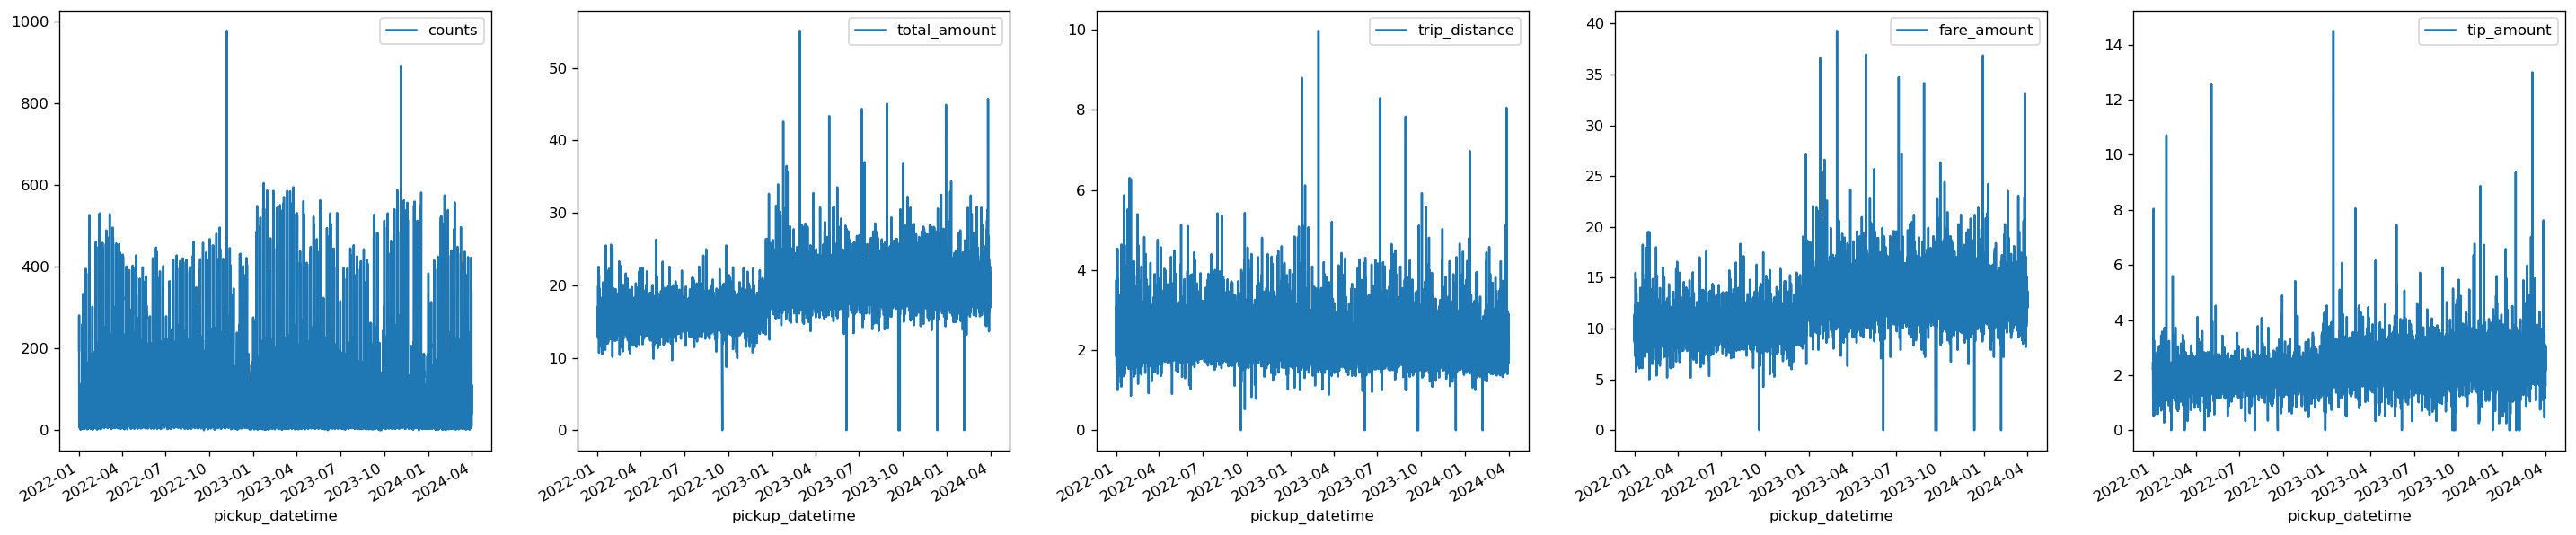

In [12]:
fig, axes = plt.subplots(figsize = (6*5, 6), dpi = 120, nrows = 1, ncols = 5)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount']):
    ts_79_p.plot(x = 'pickup_datetime', y = col, ax = axes[i])

In [13]:
# save time series as pd dataframe
os.system('mkdir -p ../../processed_taxi_data')
ts.to_pickle('../../processed_taxi_data/yellow_2022-01_2024-03.pkl')

### create adjusted price to account for rate hike
Effective: Dec. 19, 2022

Increase: 23%

In [14]:
ts_79_p

,pickup_datetime,PULocationID,counts,total_amount,fare_amount,tip_amount,trip_distance
0,2022-01-01 00:00:00-05:00,79,196,15.841020,9.813776,2.227245,2.186888
1,2022-01-01 01:00:00-05:00,79,281,16.003025,9.969751,2.231495,2.345907
2,2022-01-01 02:00:00-05:00,79,266,16.415376,10.146617,2.476278,2.443459
3,2022-01-01 03:00:00-05:00,79,213,16.935681,10.814554,2.321127,2.743005
4,2022-01-01 04:00:00-05:00,79,118,15.680593,9.970339,1.910254,2.533644
...,...,...,...,...,...,...,...
19623,2024-03-31 19:00:00-04:00,79,95,20.679369,13.588421,3.054105,2.213263
19624,2024-03-31 20:00:00-04:00,79,110,19.351636,11.985454,2.438909,1.885273
19625,2024-03-31 21:00:00-04:00,79,95,20.171263,12.446316,2.724947,2.013263
19626,2024-03-31 22:00:00-04:00,79,66,21.524697,13.754546,2.770152,2.365303


In [15]:
import datetime as dt
fare_hike_date = pd.Timestamp('2022-12-19 00:00:00').tz_localize('America/New_York', ambiguous = True) # need to specify time zone to avoid ambiguity
ts_hike = ts_79_p[(ts_79_p['pickup_datetime'] >= fare_hike_date - pd.Timedelta(days = 30)) & (ts_79_p['pickup_datetime'] <= fare_hike_date + pd.Timedelta(days = 30))]
ts_hike.pickup_datetime.min(), ts_hike.pickup_datetime.max()

(Timestamp('2022-11-19 00:00:00-0500', tz='America/New_York'),
 Timestamp('2023-01-18 00:00:00-0500', tz='America/New_York'))

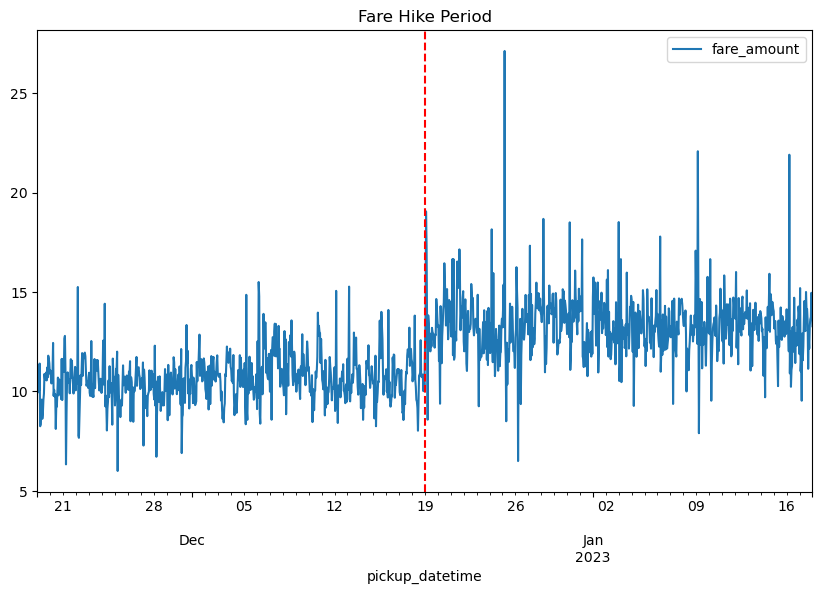

In [16]:
ts_hike.plot(x = 'pickup_datetime', y = 'fare_amount', figsize = (10, 6), title = 'Fare Hike Period')
plt.axvline(fare_hike_date, color = 'r', linestyle = '--')

In [17]:
ts_adj = ts_79_p.copy()
ts_adj['fare_amount'] = np.where(ts_adj['pickup_datetime'] <= fare_hike_date, ts_adj['fare_amount'] * 1.23, ts_adj['fare_amount'])

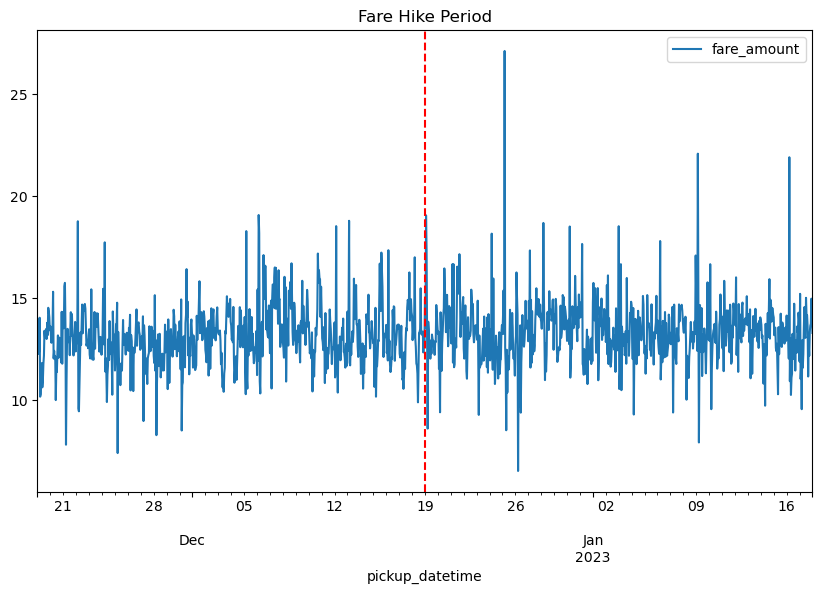

In [18]:
ts_adj_hike = ts_adj[(ts_adj['pickup_datetime'] >= fare_hike_date - pd.Timedelta(days = 30)) & (ts_adj['pickup_datetime'] <= fare_hike_date + pd.Timedelta(days = 30))]
ts_adj_hike.plot(x = 'pickup_datetime', y = 'fare_amount', figsize = (10, 6), title = 'Fare Hike Period')
plt.axvline(fare_hike_date, color = 'r', linestyle = '--')

### correct for fare hike and save dataframe

In [19]:
ts_adj = ts.copy()
prices = ['fare_amount', 'total_amount', 'tip_amount']
for price in prices:
    ts_adj[price] = np.where(ts['pickup_datetime'] <= fare_hike_date, ts[price] * 1.23, ts[price])

In [20]:
ts_adj_79 = ts_adj[ts_adj['PULocationID'] == 79]
gb = ts_adj_79.groupby(['pickup_datetime', 'PULocationID'])

In [21]:
# weighted-average function accounting for zero-weights
def weighted_average(x, weights):
    if weights.sum() == 0.:
        return 0.
    return np.average(x, weights=weights)

# from groupby, sum the counts and perform weighted average of total_amount, etc. using counts as weights
ts_adj_79_p = pd.DataFrame(gb['counts'].sum())
ts_adj_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
ts_adj_79_p['fare_amount'] = gb.apply(lambda x: weighted_average(x['fare_amount'], weights=x['counts']))
ts_adj_79_p['tip_amount'] = gb.apply(lambda x: weighted_average(x['tip_amount'], weights=x['counts']))
ts_adj_79_p['trip_distance'] = gb.apply(lambda x: weighted_average(x['trip_distance'], weights=x['counts']))
ts_adj_79_p = ts_adj_79_p.reset_index()

/tmp/ipykernel_5363/3051142293.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_adj_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
/tmp/ipykernel_5363/3051142293.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_adj_79_p['fare_amount'] = gb.apply(lambda x: weighted_average(x['fare_amount'], weights=x['counts']))
/tmp/ipykernel_5363/3051142293.

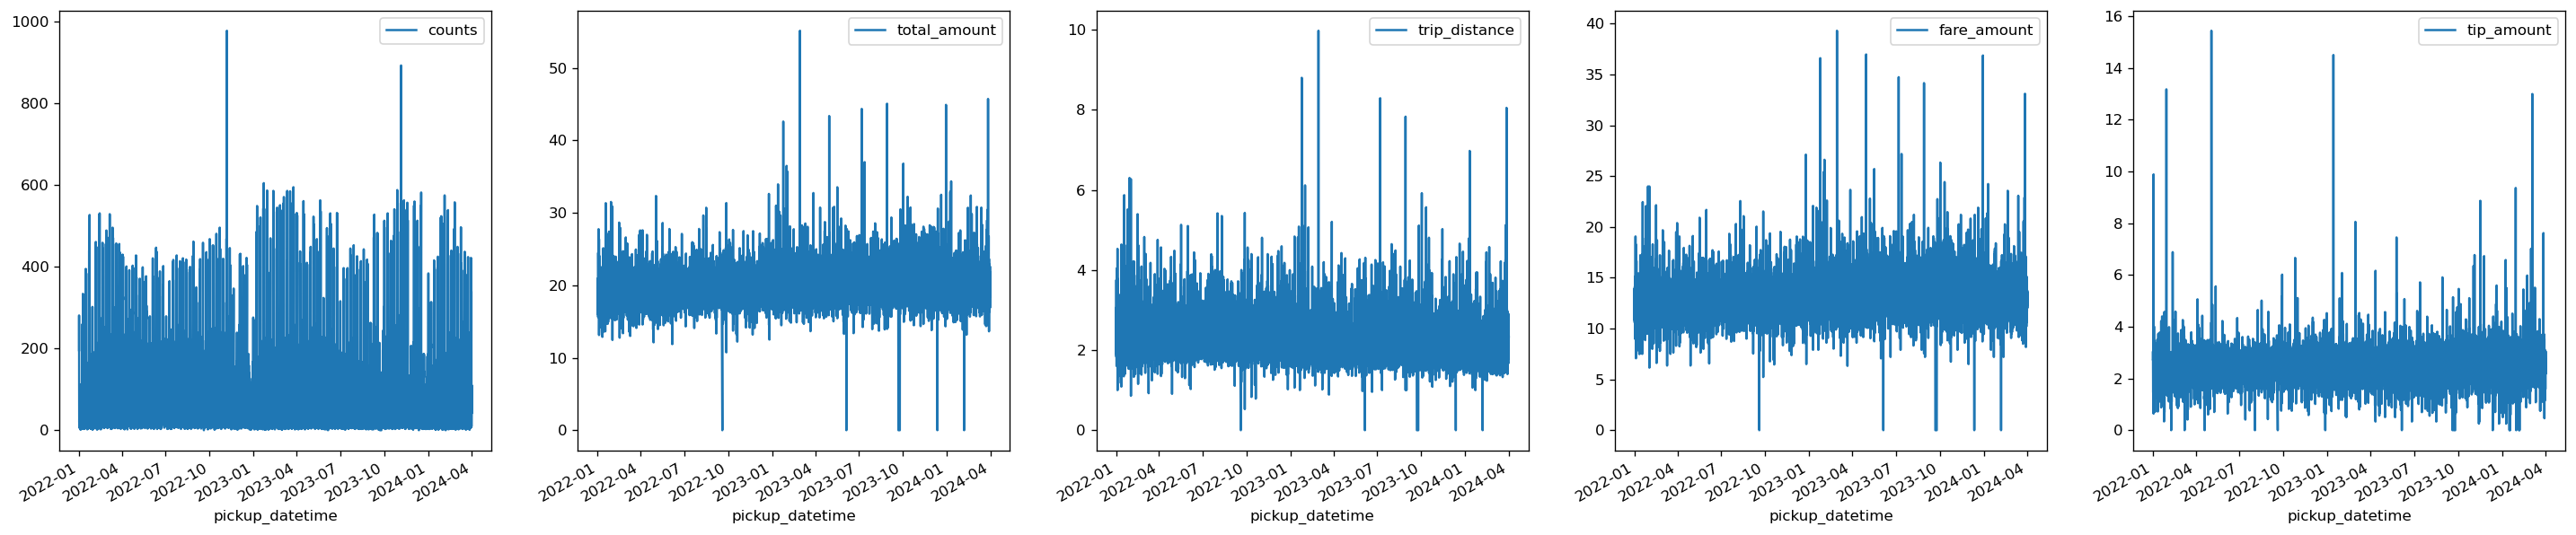

In [22]:
fig, axes = plt.subplots(figsize = (6*5, 6), dpi = 120, nrows = 1, ncols = 5)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount']):
    ts_adj_79_p.plot(x = 'pickup_datetime', y = col, ax = axes[i])

In [23]:
# save time series as pd dataframe outside github repo
os.system('mkdir -p ../../processed_taxi_data')
ts.to_pickle('../../processed_taxi_data/adjusted_yellow_2022-01_2024-03.pkl')